In [2]:
%config IPCompleter.greedy=True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [4]:
#ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
#movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
#tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
#links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

In [5]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')

# Dataset

In [6]:
percentage = 1
#movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))
ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [7]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [8]:
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
249995,1751,161,3.0,945125051
249996,1751,163,2.0,945127081
249997,1751,164,1.0,945126546
249998,1751,175,5.0,945124825


In [9]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [10]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

1751
13989


# Spotlight

## Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used when needed.

In [11]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (1, uid_map[3]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 1 got uid 2
movieId 54001 got iid 557


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

## Implicit Factorization model

In [12]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids,
                                   timestamps = timestamps)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [13]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (1751 users x 13989 items x 160000 interactions)>
<Interactions dataset (1751 users x 13989 items x 50000 interactions)>
<Interactions dataset (1751 users x 13989 items x 40000 interactions)>
<Interactions dataset (1751 users x 13989 items x 128000 interactions)>
<Interactions dataset (1751 users x 13989 items x 32000 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [14]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    #FOR EACH INTERACTION
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId'] == converted_movies[i]) & (
            ratings_df['userId'] == converted_users[i])].values))

    df = pd.DataFrame({'user_id': converted_users,
                       'movie_id': converted_movies, 'rating': rating})
    return df

In [15]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

### Pickle 

Save

In [440]:
train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")
train_features_df.to_pickle("./train_features_df.pkl")
train_labels_df.to_pickle("./train_labels_df.pkl")

Load

In [17]:
'''train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")'''

'train_df = pd.read_pickle("./train_df.pkl")\ntest_df = pd.read_pickle("./test_df.pkl")\nval_df = pd.read_pickle("./val_df.pkl")'

### Train Implicit Factorization model 

In [18]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.5641468086242676
Epoch 1: loss 0.34202599053382876
Epoch 2: loss 0.3064313257932663
Epoch 3: loss 0.2765338787317276
Epoch 4: loss 0.24909528198242187
Training took 101 second


Distribution of scores for a user

(array([1.000e+00, 2.000e+00, 4.000e+00, 3.300e+01, 1.190e+02, 3.240e+02,
        6.860e+02, 1.259e+03, 1.805e+03, 1.953e+03, 1.680e+03, 1.081e+03,
        7.050e+02, 5.810e+02, 5.460e+02, 4.230e+02, 3.440e+02, 2.750e+02,
        2.230e+02, 1.820e+02, 1.820e+02, 1.270e+02, 1.200e+02, 1.390e+02,
        1.190e+02, 1.200e+02, 1.130e+02, 9.900e+01, 1.020e+02, 9.700e+01,
        8.500e+01, 1.080e+02, 8.000e+01, 8.900e+01, 5.800e+01, 5.400e+01,
        4.100e+01, 1.900e+01, 8.000e+00, 3.000e+00]),
 array([-14.410983  , -13.658067  , -12.905151  , -12.152235  ,
        -11.39932   , -10.646403  ,  -9.893488  ,  -9.140572  ,
         -8.387656  ,  -7.63474   ,  -6.881824  ,  -6.128908  ,
         -5.3759923 ,  -4.6230764 ,  -3.8701603 ,  -3.1172445 ,
         -2.3643286 ,  -1.6114126 ,  -0.8584968 ,  -0.10558085,
          0.64733505,   1.4002509 ,   2.1531668 ,   2.9060829 ,
          3.6589987 ,   4.411915  ,   5.1648307 ,   5.9177465 ,
          6.6706624 ,   7.4235783 ,   8.176495  ,   8.

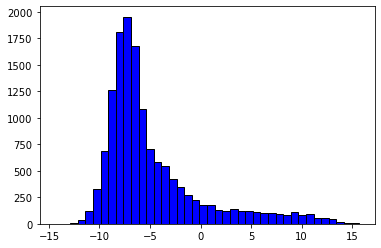

In [19]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [20]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[296, 4973, 1, 110, 150, 260, 318, 356, 364, 380, 457, 480, 588, 589, 858, 1136, 1196, 1197, 1198, 1210, 1287, 1356, 2571, 3578, 4963, 32, 50, 293, 541, 593, 778, 780, 912, 924, 1089, 1200, 1213, 1214, 1221, 2329, 2858, 2959, 4226, 1036, 1265, 47, 231, 253, 288, 300, 344, 440, 590, 592, 595, 608, 736, 784, 919, 1203, 1704, 165, 185, 6, 11, 16, 21, 112, 163, 223, 316, 377, 454, 551, 594, 750, 904, 1101, 1259, 1729, 34, 158, 539, 586, 597, 1219, 1307, 1387, 5060, 160, 367, 368, 508, 543, 1223, 1094, 339, 509, 282, 1199]


In [21]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

In [22]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
10,11,"American President, The (1995)",Comedy|Drama|Romance
15,16,Casino (1995),Crime|Drama
20,21,Get Shorty (1995),Comedy|Crime|Thriller
...,...,...,...
3479,3578,Gladiator (2000),Action|Adventure|Drama
4122,4226,Memento (2000),Mystery|Thriller
4857,4963,Ocean's Eleven (2001),Crime|Thriller
4867,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance


In [23]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Μovies watched from a user

In [24]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [25]:
actual = actual.index.tolist()

In [26]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
302,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
303,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
654,665,Underground (1995),Comedy|Drama|War
878,899,Singin' in the Rain (1952),Comedy|Musical|Romance
...,...,...,...
9122,27193,Taxi 2 (2000),Action|Comedy
9145,27266,2046 (2004),Drama|Fantasy|Romance|Sci-Fi
9306,27721,"Very Long Engagement, A (Un long dimanche de f...",Drama|Mystery|Romance|War
9647,31956,5x2 (2004),Drama|Romance


In [27]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score

In [28]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

In [29]:
rec_forUser == allUsers_topK_imp[0]

True

In [30]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [31]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

In [32]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

In [33]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [34]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [35]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [36]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [37]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

nan
nan


C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [38]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [39]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [40]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

In [41]:
np.array(allUsers_implicit_ndcg).mean()

0.3382044798746844

### MRR Score

In [42]:
#Calculate reciprocal rank. Where is the first relevant item?
def RR_forUsers(relevance):
    count = 0
    reciprocal_rank_perUser = []
    #for each user
    first_perUser = 0
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                #1/position
                first_perUser = 1/count
                #stop the iteration. Only care about the first relevant item
                break
        reciprocal_rank_perUser.append(first_perUser)
        count = 0
    return reciprocal_rank_perUser

In [43]:
rr_implicit = RR_forUsers(relevance_implicit_full)

In [44]:
def calculate_mrr(rr):    
    #or np.array(rr).mean()
    return np.array(rr).sum()/len(rr)

In [45]:
implicit_mrr = calculate_mrr(rr_implicit)

In [46]:
implicit_mrr

0.21698966339709702

### MAP Score

In [47]:
#calculate average precision.
def calculate_averagePrecision(relevance):
    count_positive = 0
    positives = []
    ap_perUser = []
    count = 0
    #for each user
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                count_positive += 1
                #First, second, etc. relevant item/ position
                positives.append(count_positive/count)
        #mean of relevant item/position
        ap_perUser.append(np.array(positives).sum()/count_positive)
        count_positive = 0
        positives = []
        count = 0
    return ap_perUser

In [48]:
implicit_ap = calculate_averagePrecision(relevance_implicit_full)
implicit_ap = pd.Series(implicit_ap).fillna(0).tolist()

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
def calculate_MAP(ap):
    #or np.array(ap).mean()
    return np.array(ap).sum()/len(ap)

In [50]:
implicit_map = calculate_MAP(implicit_ap)
implicit_map

0.1119401559904688

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [51]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [52]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,205413,205583,205945,205967,206272,206499,206523,206805,208002,208793
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1748,4.5,0.0,2.5,0.0,0.0,4.0,3.5,0.0,1.5,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [53]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [54]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [55]:
svd_predictions_score[1]

array([ 1.97628031e+00,  6.21036544e-01,  2.73862429e-01, ...,
       -5.35596387e-04, -7.64600501e-04, -9.54211695e-02])

In [56]:
svd_predictions_score_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,205413,205583,205945,205967,206272,206499,206523,206805,208002,208793
0,0.053522,0.000806,-0.038430,-0.001446,-0.029590,0.066003,-0.045710,-0.008940,-0.023953,-0.010842,...,-0.002441,-0.000957,0.000769,-0.001116,-0.000182,0.014753,0.001100,0.000369,0.000321,0.005475
1,1.976280,0.621037,0.273862,0.008414,0.097872,-0.073535,0.462352,0.108453,0.021690,0.534919,...,0.022292,-0.023064,0.001089,-0.026908,0.001163,0.014008,0.003608,-0.000536,-0.000765,-0.095421
2,1.273750,0.522894,-0.095295,-0.099711,-0.074205,0.623712,-0.212212,-0.059051,0.083723,0.362515,...,-0.014390,0.041347,0.000547,0.048238,0.018652,0.003778,0.026377,0.010274,0.026128,0.073706
3,1.020807,0.340406,-0.110325,-0.029105,-0.020913,0.001317,-0.046516,-0.022725,-0.021896,0.046821,...,0.027517,0.018157,0.001529,0.021184,0.012936,0.001718,0.011851,0.003854,0.009942,0.056347
4,1.102959,0.504278,0.303489,0.063907,0.274676,0.431977,0.374920,0.061169,0.066189,0.697463,...,0.014313,0.001109,0.000142,0.001294,-0.000027,-0.012312,-0.001637,-0.000637,-0.001784,0.005970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.386140,0.014566,0.089429,0.029411,0.103880,0.311889,0.170334,0.010817,0.035361,0.144698,...,-0.010278,-0.005947,-0.000810,-0.006938,-0.002225,-0.007808,-0.000225,0.001402,0.005253,-0.007626
1747,1.622186,0.944563,2.726531,0.162702,1.917650,3.646636,3.815768,0.570992,0.860720,3.495834,...,-0.139470,0.024643,-0.015875,0.028751,-0.019956,0.023613,0.020888,0.022381,0.029074,-0.100325
1748,1.247515,0.444830,0.333566,0.041766,0.147647,0.341185,0.479784,0.069693,0.088834,0.526158,...,0.027665,0.009247,-0.000376,0.010788,-0.000713,-0.003592,-0.003720,-0.002621,-0.005941,-0.010692
1749,0.295229,0.077300,0.031521,0.005950,0.008375,-0.049617,0.065602,0.013506,-0.007865,0.030201,...,0.007698,-0.003305,0.000439,-0.003855,0.000192,-0.001247,0.000094,-0.000295,-0.001112,-0.005698


In [57]:
svd_predictions_score_df[svd_predictions_score_df.index == 609]

movie_id,1,2,3,4,5,6,7,8,9,10,...,205413,205583,205945,205967,206272,206499,206523,206805,208002,208793
609,0.864562,0.143526,-0.102825,-0.022103,-0.12585,0.134818,-0.123501,-0.033017,-0.052288,0.010628,...,0.003101,0.003426,0.001302,0.003996,0.003562,0.009957,0.004895,0.001223,0.005626,-0.001452


## Top-K recommendations

The function below returns a list that contains the top-100 recommendations for each user

In [58]:
svd_predictions_score_df[svd_predictions_score_df.index == 0].values[0]

array([ 0.05352169,  0.00080574, -0.03843035, ...,  0.00036924,
        0.00032108,  0.00547463])

In [59]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    for i in range(len(num_users)):
        svd_h_df = pd.DataFrame({'movie_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['movie_id'].values)
    return topK_svd_rec

In [60]:
a = SVD_topK_first(svd_predictions_score_df)

In [61]:
a[0]

array([  296,  2959,  4226,  4973,  2858,  7361,    50,  2997,   318,
          47,   778,  4993,  1732,  3949,  2329,  6874,  7438,  6711,
         356,  1089,  4878,  7153,  2542,  4979,   593,  2571,  2692,
        5669,   293,  2502,  3897,    32,  1258,  8874,   608,  1206,
        4027,  3996,  5618,  4011,  1136,   750, 46578,  8961,  5952,
        7147,  3481,   111,  4306,  6016,  6377, 48394,  1682,  2762,
        4963,   223,  1193,  5902,  6539,  5989, 32587,  1704,  5377,
       48516,  1784,  1265,  3160,  1199,   541,  3147,   527,  4995,
         555, 55820, 27773,  4022, 63082, 30749,  8949,  3052,  2028,
        4235,  1222,  2324,   924,  3911, 48774,  8784,  3253,  1923,
        3114,  6502,  5445, 44555,  1208,  2291,   551,  4848,   337,
        1617], dtype=int64)

## NDCG Score

The function below returns the relevance list of a list of movies.

In [62]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [63]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [64]:
np.asarray(relevance_first).shape

(1751, 100)

In [65]:
n_f = NDCG_forUser(relevance_first[0])

In [66]:
n_f

0.25190169965869874

Below is the NDCG scores of each user

In [67]:
all_ndcg_f = allUsers_ndcg(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [68]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [69]:
np.asarray(all_ndcg_f).mean()

0.4017750206847398

## MRR Score

In [70]:
svd_rr = RR_forUsers(relevance_first)
svd_mrr = calculate_mrr(svd_rr)
svd_mrr

0.2531083091540555

## MAP Score

In [71]:
svd_ap = calculate_averagePrecision(relevance_first)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
svd_map

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0.14178469851489087

# Feature Engineering 

At this Chapter the goal is to create features to give as an input to the lightGBM model.

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [72]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.6061473124623299
Epoch 1: loss 0.35230512034893036
Epoch 2: loss 0.31805565321445467
Epoch 3: loss 0.2846406335532665
Epoch 4: loss 0.2546952330172062
Training took 72 second


### Target Movies

In [73]:
#allUsers_topK_f1 = allUsers_topK_implicit(f1_model)
#target_positive = allUsers_topK_f1

In [74]:
def getImplicitTop():
    moviePerUser = []
    rev = []
    for user in range(len(num_users)):
        pred = f1_model.predict(user)
        #sort by score in descending order oscer
        predMovieId = np.argsort(-pred)
        #keep top 100
        predMovieId = predMovieId[:100]
        #reverse the mapping to get the original movieIDs
        for movie in predMovieId:
            rev.append(iid_rev_map[movie])
        moviePerUser.append(rev)
        rev = []
    return moviePerUser

In [75]:
target_positive = getImplicitTop()

Add negative samples to the target movies

In [76]:
import random
target_negative = []
for i in range(1,len(num_users)+1):
    #get 50 random movieIDs for each user
    target_negative.append(random.choices(train_features_df['movie_id'].values, k = 50))

Merge the top-100 and the negative samples to provide the target movies.

In [77]:
target_movies = []
for i in range(len(num_users)):
    target_movies.append(target_positive[i] + target_negative[i])

Map the target movies to pick the correct predictions based on the item id

In [78]:
def map_movies(target_movies):
    map_target_movies = []
    map_help = []
    for movies in target_movies:
        for movie in movies:
            map_help.append(iid_map[movie])
        map_target_movies.append(map_help)
        map_help = []
    return map_target_movies

In [79]:
def give_movies_implicit_scores(map_movies):
    implicit_scores = 0
    feature = []
    for i in range(len(num_users)):
        #for movies in map_target_movies:
        my_list = map_movies[i]
        my_array = np.array(my_list)
        implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
        feature.append(implicit_scores)
    return feature

In [80]:
map_target_movies = map_movies(target_movies)
feature1 = give_movies_implicit_scores(map_target_movies)
feature1 = np.asarray(feature1)

In [81]:
feature1[0]

array([11.013071  , 10.311844  , 10.272123  , 10.202899  ,  9.976336  ,
        9.959671  ,  9.92032   ,  9.837716  ,  9.760242  ,  9.7346945 ,
        9.718807  ,  9.665363  ,  9.6050825 ,  9.4388    ,  9.398109  ,
        9.3655405 ,  9.334089  ,  9.324064  ,  9.317705  ,  9.276563  ,
        9.212168  ,  9.211037  ,  9.204023  ,  9.190827  ,  9.147732  ,
        9.129514  ,  9.122598  ,  9.033224  ,  9.0122    ,  8.999216  ,
        8.986158  ,  8.877889  ,  8.855695  ,  8.853727  ,  8.810584  ,
        8.800085  ,  8.798563  ,  8.76443   ,  8.71561   ,  8.701898  ,
        8.657083  ,  8.650589  ,  8.624446  ,  8.556703  ,  8.556305  ,
        8.542473  ,  8.536426  ,  8.517015  ,  8.502443  ,  8.480003  ,
        8.476165  ,  8.4346075 ,  8.397086  ,  8.388987  ,  8.382501  ,
        8.37152   ,  8.356326  ,  8.342188  ,  8.332114  ,  8.32564   ,
        8.318043  ,  8.3009405 ,  8.273929  ,  8.25511   ,  8.241516  ,
        8.206845  ,  8.192677  ,  8.1813345 ,  8.143638  ,  8.13

## Feature 2 (Implicit Rank)

In [82]:
feature2 = []
for i in range(len(num_users)):
    #my_list = map_target_movies[i]
    #my_array = np.array(my_list)
    feature2 = (st.rankdata(-f1_model.predict(i)))
    feature2 = feature2[map_target_movies]
    feature2.sort()

In [83]:
feature2[0]

array([1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 6.0000e+00,
       7.0000e+00, 8.0000e+00, 9.0000e+00, 9.0000e+00, 1.0000e+01,
       1.1000e+01, 1.2000e+01, 1.4000e+01, 1.6000e+01, 1.7000e+01,
       1.8000e+01, 1.8000e+01, 1.9000e+01, 2.0000e+01, 2.2000e+01,
       2.3000e+01, 2.4000e+01, 2.5000e+01, 2.6000e+01, 2.7000e+01,
       2.8000e+01, 2.9000e+01, 3.0000e+01, 3.1000e+01, 3.3000e+01,
       3.5000e+01, 3.6000e+01, 3.8000e+01, 3.9000e+01, 4.0000e+01,
       4.1000e+01, 4.2000e+01, 4.3000e+01, 4.4000e+01, 4.4000e+01,
       4.7000e+01, 4.8000e+01, 5.0000e+01, 5.2000e+01, 5.5000e+01,
       5.7000e+01, 6.0000e+01, 6.1000e+01, 6.3000e+01, 6.5000e+01,
       6.7000e+01, 6.8000e+01, 7.2000e+01, 7.3000e+01, 7.4000e+01,
       7.6000e+01, 7.7000e+01, 8.1000e+01, 8.3000e+01, 8.6000e+01,
       8.9000e+01, 8.9000e+01, 9.0000e+01, 9.3000e+01, 9.6000e+01,
       1.0400e+02, 1.0500e+02, 1.0800e+02, 1.1100e+02, 1.1400e+02,
       1.1500e+02, 1.1700e+02, 1.1900e+02, 1.2100e+02, 1.2200e

In [84]:
feature2 = np.array(feature2)

In [85]:
print(feature2.shape)
feature2[0][0:150]

(1751, 150)


array([1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 6.0000e+00,
       7.0000e+00, 8.0000e+00, 9.0000e+00, 9.0000e+00, 1.0000e+01,
       1.1000e+01, 1.2000e+01, 1.4000e+01, 1.6000e+01, 1.7000e+01,
       1.8000e+01, 1.8000e+01, 1.9000e+01, 2.0000e+01, 2.2000e+01,
       2.3000e+01, 2.4000e+01, 2.5000e+01, 2.6000e+01, 2.7000e+01,
       2.8000e+01, 2.9000e+01, 3.0000e+01, 3.1000e+01, 3.3000e+01,
       3.5000e+01, 3.6000e+01, 3.8000e+01, 3.9000e+01, 4.0000e+01,
       4.1000e+01, 4.2000e+01, 4.3000e+01, 4.4000e+01, 4.4000e+01,
       4.7000e+01, 4.8000e+01, 5.0000e+01, 5.2000e+01, 5.5000e+01,
       5.7000e+01, 6.0000e+01, 6.1000e+01, 6.3000e+01, 6.5000e+01,
       6.7000e+01, 6.8000e+01, 7.2000e+01, 7.3000e+01, 7.4000e+01,
       7.6000e+01, 7.7000e+01, 8.1000e+01, 8.3000e+01, 8.6000e+01,
       8.9000e+01, 8.9000e+01, 9.0000e+01, 9.3000e+01, 9.6000e+01,
       1.0400e+02, 1.0500e+02, 1.0800e+02, 1.1100e+02, 1.1400e+02,
       1.1500e+02, 1.1700e+02, 1.1900e+02, 1.2100e+02, 1.2200e

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [86]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [87]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [88]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,204780,204832,205054,205156,205583,205945,205967,206805,208002,208793
0,-0.042026,-0.039977,-0.023502,-0.002605,-0.026982,0.068352,-0.026773,-0.011726,0.002201,-0.048719,...,0.019288,0.000135,-0.000851,0.019288,0.000968,0.000135,0.001129,0.000637,0.001597,0.005497


In [89]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

0.1334140039102427

In [90]:
feature3 = []
feature3_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [91]:
np.array(feature3).shape

(1751, 150)

## Feature 4 (Genre)

In [92]:
def create_genre_feature(genre):
    feature = []
    genre_per_user = []
    for i in range(len(num_users)):
        for j in range(len(target_movies[i])):
            a =  movies_df[movies_df['movieId'] == target_movies[i][j]]['genres']
            a = a.tolist()
            a = str(a[0])
            a = a.split('|')
            if genre in a:
                #print(a)
                genre_per_user.append(1)
            else:
                genre_per_user.append(0)
        feature.append(genre_per_user)
        genre_per_user = []
    return feature

In [93]:
feature4 = create_genre_feature('Comedy')
np.array(feature4).shape

(1751, 150)

### Features 8-15 (genres)

In [94]:
feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')

## Feature 5 (#Users watched each target movie)

In [95]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['movieId'] == target_movies[i][j]]['userId'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [96]:
feature5 = number_views

In [97]:
np.array(feature5).shape

(1751, 150)

## Feature 6 (New user)

In [98]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['userId']==i]) < 25
        if a:
            binary_per_user.append(a)
        else:
            binary_per_user.append(a)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [99]:
#rankings of old/new users

In [100]:
feature6 = new_users_binary

In [101]:
np.array(feature6).shape

(1751, 150)

Check how many the new users are

In [102]:
count = 0
for i in range(len(num_users)):
    if True in feature6[i]:
        count += 1
print(count)

176


## Feature 7(Embeddings) x32

In [103]:
emb = f1_model._net.item_embeddings

In [104]:
emb_features = []
helper = []
for i in range(32):
    for j in range(len(num_items)):
        helper.append(emb.weight[j][i].item())
    emb_features.append(helper)
    helper = []

In [105]:
a = []
b = []
feature7 = []
for i in range(32):
    for user in range(len(num_users)):
        for movie in map_target_movies[user]:
            a.append(emb_features[0][movie])
        b.append(a)
        a = []
    feature7.append(b)
    b = []

In [106]:
np.array(feature7).shape

(32, 1751, 150)

In [107]:
np.array(feature7[0]).shape

(1751, 150)

## Feature 47 (SVD Rank)

In [108]:
feature47 = []
feature47_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature47_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature47.append(st.rankdata(-np.array(feature47_user)))
    feature47_user = []

In [109]:
'''feature48 = []
for i in range(len(num_users)):
    feature48.append((st.rankdata(-np.array(feature3[i]))))'''

'feature48 = []\nfor i in range(len(num_users)):\n    feature48.append((st.rankdata(-np.array(feature3[i]))))'

In [110]:
np.array(feature47).shape

(1751, 150)

In [111]:
feature47[0]

array([ 19. ,  92. , 112. ,  85. , 150. ,  38. ,  30. ,   9.5,  11. ,
        27. ,   7. , 142. , 140. ,  45. ,   2. ,  79. , 149. ,  82. ,
        26. , 101. ,  63. , 108. ,  14. ,  51. , 129. , 100. ,  36. ,
       145.5, 136. ,  25. ,  62. , 139. ,  99. , 119. , 134. ,  78. ,
        54. ,  29. , 138. , 113. , 106. ,  23. , 120. ,  65.5,  64. ,
         4. , 127. , 110.5,   8. ,  24. ,  22. , 116. , 143. , 128. ,
         6. ,  96. ,  44. , 132. , 115. ,  77. ,  40. ,   1. , 123. ,
       133. , 131. ,  41. , 105. ,  47. ,  73. ,  17. , 114. , 135. ,
       147. , 141. , 137. ,  34. ,  18. ,  46. ,  53. ,  48. ,   3. ,
       122. ,  70. ,  50. ,  12. ,  37. ,  90. , 121. , 103. ,  88. ,
       148. ,  60. ,  56. , 109. , 118. ,  42. , 130. , 144. ,  28. ,
       124. ,  13. ,  61. ,   5. ,  71. , 107. ,  84. , 125. ,  76. ,
        33. ,  21. ,  93. ,  58. ,  68. ,  94. ,  74. , 145.5,  75. ,
        59. ,  97.5, 104. ,  89. , 102. ,  43. ,  52. ,  67. ,  83. ,
        87. ,  91. ,

## Features stack

In [549]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [523]:
features = np.stack((feature1, feature2, feature3,feature4))

In [550]:
lenFeatures = len(features)

## Labels

Below are the movies that each user watched

In [115]:
def watched_movies(df):
    watched = []
    #for i in range(len(num_users)):
    for u in uid_rev_map:
        watched.append(df[df["user_id"]==uid_rev_map.get(u)].groupby("movie_id")["movie_id"].count().index.tolist())  
    return watched 

In [116]:
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [117]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [118]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

# LightGBM 

## Prepare X y

In [525]:
k = len(target_movies[0])

X = np.array(features)
#X = X.reshape(len(num_users)*k,len(features))
X = X.reshape(len(features), len(num_users)*k)
X = np.transpose(X)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [526]:
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

In [527]:
X_train = X
X_test = X
X_val = X

In [528]:
X.shape

(262650, 4)

## Classifier

In [389]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [390]:
p = 0
m = k
clf_pred_per_user = []
for i in range(len(num_users)):
    clf_pred_per_user.append(y_pred[p:m])
    p += k
    m += k

In [391]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9618


In [392]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    252648
           1       0.00      0.00      0.00     10002

    accuracy                           0.96    262650
   macro avg       0.48      0.50      0.49    262650
weighted avg       0.93      0.96      0.94    262650



In [393]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9755
Test set score: 0.9618


The training and test set accuracy are quite comparable. So, we cannot say there is overfitting.

In [394]:
lgbm_clf_ndcg = NDCG_forUser(y_pred)

In [395]:
lgbm_clf_ndcg

0.19425603869126196

In [396]:
clf_rr = RR_forUsers(clf_pred_per_user)
clf_rr = pd.Series(clf_rr).fillna(0).tolist()

In [397]:
clf_MRR = calculate_mrr(clf_rr)

In [398]:
clf_MRR

0.009095236700136938

In [399]:
clf_ap = calculate_averagePrecision(clf_pred_per_user)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [400]:
clf_ap = pd.Series(clf_ap).fillna(0).tolist()
clf_map = calculate_MAP(clf_ap)
clf_map

0.00012563950513001318

## Ranker

In [551]:
import lightgbm as lgb
param = {
    "task": "train",
    "num_leaves": 255,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 100,
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [1, 5, 10, 20],
    "learning_rate": .1,
    "num_threads": 2,
}
gbm = lgb.LGBMRanker()
gbm.set_params(**param)

LGBMRanker(metric='ndcg', min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
           ndcg_eval_at=[1, 5, 10, 20], num_leaves=255, num_threads=2,
           objective='lambdarank', task='train')

In [552]:
#gbm = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
#                     num_leaves=31, min_child_weight=100)

In [553]:
#print(len(train_df.user_id.unique()))
#print(len(test_df.user_id.unique()))
#print(len(val_df.user_id.unique()))
#print(len(train_features_df.user_id.unique()))
#print(len(train_labels_df.user_id.unique()))

In [554]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)

[262650]
[262650]
[262650]


In [555]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 5, 10, 20], eval_metric='ndcg', verbose = 0)

LGBMRanker(metric='ndcg', min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
           ndcg_eval_at=[1, 5, 10, 20], num_leaves=255, num_threads=2,
           objective='lambdarank', task='train')

In [556]:
gbm.best_iteration_

### Predictions

In [557]:
test_pred = gbm.predict(X_test)
np.array(test_pred).shape

(262650,)

In [558]:
p = 0
m = k
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += k
    m += k

### NDCG Score

In [559]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
ifm_relevance_list = []
svd_relevance_list = []
lgbm_relevance_list = []

for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                             'rank': feature2[i], 'model2_score': feature3[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    ifm_relevance_list.append(ifm_relevance)
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    svd_relevance_list.append(svd_relevance_h)
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [560]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

# Comparisons

## NDCG 

In [561]:
ndcg_df = pd.DataFrame({'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG, 'SVD_this': SVD_NDCG})

In [562]:
ndcg_df

,LightGBM,IFM_this,SVD_this
0,0.000000,0.000000,0.000000
1,0.463916,0.501510,0.533584
2,0.514644,0.547994,0.547766
3,0.612480,0.592043,0.620817
4,0.536483,0.445029,0.548232
...,...,...,...
1746,0.564092,0.495493,0.557886
1747,0.569881,0.675221,0.668396
1748,0.362314,0.355868,0.402764
1749,0.000000,0.000000,0.000000


In [563]:
lgbm_mean = ndcg_df['LightGBM'].mean()
lgbm_mean

0.3654848912064088

In [564]:
ifm_mean = ndcg_df['IFM_this'].mean()
ifm_mean

0.32936666346851234

In [565]:
svd_mean = ndcg_df['SVD_this'].mean()
svd_mean

0.37396645781670856

## MRR

In [546]:
ifm_rr = RR_forUsers(ifm_relevance_list)
ifm_mrr = calculate_mrr(ifm_rr)
svd_rr = RR_forUsers(svd_relevance_list)
svd_mrr = calculate_mrr(svd_rr)
lgbm_rr = RR_forUsers(lgbm_relevance_list)
lgbm_mrr = calculate_mrr(lgbm_rr)

In [547]:
print(stats.ttest_rel(ifm_rr,svd_rr))

Ttest_relResult(statistic=-6.5585431143213295, pvalue=7.132705798875891e-11)


In [548]:
print('IFM:',ifm_mrr)
print('SVD:',svd_mrr)
print('LightGBM:',lgbm_mrr)

IFM: 0.1863746925607796
SVD: 0.24200735084981456
LightGBM: 0.23794441543493117


## MAP

In [151]:
ifm_ap = calculate_averagePrecision(ifm_relevance_list)
ifm_ap = pd.Series(ifm_ap).fillna(0).tolist()
ifm_map = calculate_MAP(ifm_ap)
svd_ap = calculate_averagePrecision(svd_relevance_list)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
lgbm_ap = calculate_averagePrecision(lgbm_relevance_list)
lgbm_ap = pd.Series(lgbm_ap).fillna(0).tolist()
lgbm_map = calculate_MAP(lgbm_ap)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [152]:
print('IFM:',ifm_map)
print('SVD:',svd_map)
print('LightGBM:',lgbm_map)

IFM: 0.0975538095597335
SVD: 0.14036220431856933
LightGBM: 0.12992214812884031


## Visualization

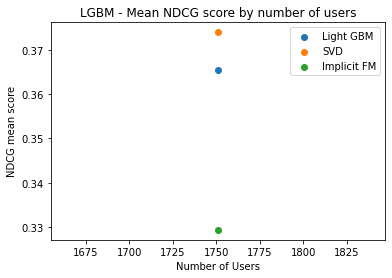

In [153]:
plt.scatter(len(num_users),lgbm_mean,label = 'Light GBM')
plt.scatter(len(num_users),svd_mean, label = 'SVD')
plt.scatter(len(num_users),ifm_mean, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('NDCG mean score')
plt.title('LGBM - Mean NDCG score by number of users')
plt.legend()

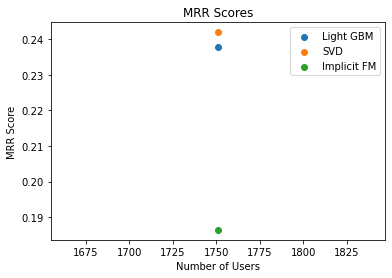

In [154]:
plt.scatter(len(num_users),lgbm_mrr,label = 'Light GBM')
plt.scatter(len(num_users),svd_mrr, label = 'SVD')
plt.scatter(len(num_users),ifm_mrr, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('MRR Score')
plt.title('MRR Scores')
plt.legend()

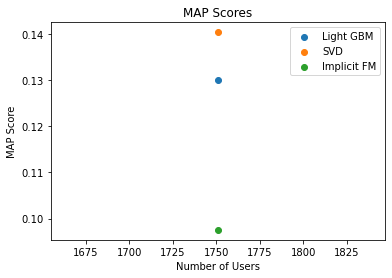

In [155]:
plt.scatter(len(num_users),lgbm_map,label = 'Light GBM')
plt.scatter(len(num_users),svd_map, label = 'SVD')
plt.scatter(len(num_users),ifm_map, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('MAP Score')
plt.title('MAP Scores')
plt.legend()

## Feature Importance

In [156]:
feature_names = excel_df.columns.values[1:5]

In [157]:
len(feature_names)

4

Text(0.5, 1.0, 'Importance of Features')

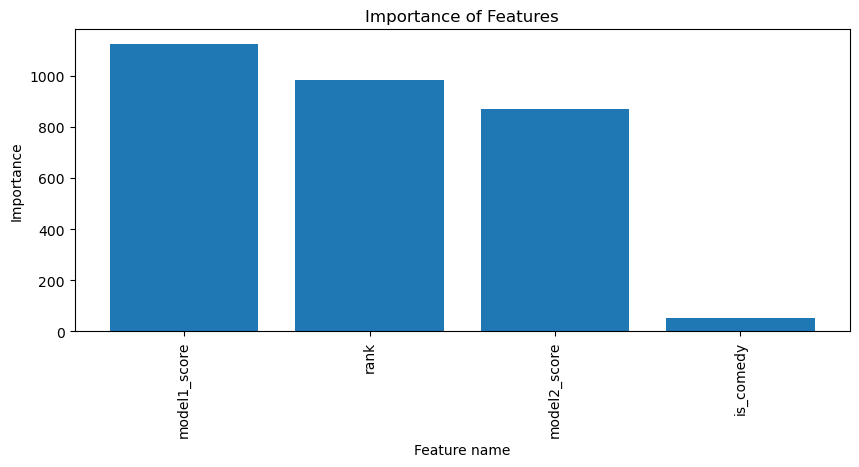

In [158]:
from matplotlib.pyplot import figure
figure(figsize=(10, 4),dpi=100)
plt.bar(feature_names,gbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [159]:
gbm.feature_importances_

array([1125,  985,  869,   53])

## Save comparison

In [160]:
#ndcg_df.to_pickle("./ndcg_f1-15_minus67_100k_negative_rank.pkl")

# Research Questions

In [161]:
'''feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')'''

"feature8 = create_genre_feature('Adventure')\nfeature9 = create_genre_feature('Drama')\nfeature10 = create_genre_feature('Romance')\nfeature11 = create_genre_feature('Fantasy')\nfeature12 = create_genre_feature('Thriller')\nfeature13 = create_genre_feature('Animation')\nfeature14 = create_genre_feature('Children')\nfeature15 = create_genre_feature('Horror')"

In [162]:
'''np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))'''

'np.stack((feature1, feature2, feature3, feature4, feature5, feature6,\n                     feature7[0], feature7[1], feature7[2], feature7[3],\n                     feature7[4], feature7[5], feature7[6], feature7[7],\n                     feature7[8], feature7[9], feature7[10], feature7[11],\n                     feature7[12], feature7[13], feature7[14], feature7[15],\n                     feature7[16], feature7[17], feature7[18], feature7[19],\n                     feature7[20], feature7[21], feature7[22], feature7[23],\n                     feature7[24], feature7[25], feature7[26], feature7[27],\n                     feature7[28], feature7[29], feature7[30], feature7[31],\n                     feature8, feature9, feature10, feature11, feature12,\n                     feature13, feature14, feature15, feature47))'

In [163]:
'''excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                         'rank': feature2[i], 'model2_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})'''

"excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],\n                         'rank': feature2[i], 'model2_score': feature3[i],\n                         'is_comedy': feature4[i], '#users_watched': feature5[i],\n                         'new_user': feature6[i],\n                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],\n                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],\n                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],\n                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],\n                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],\n                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],\n         

In [164]:
def prepareXY(features):
    X = np.array(features)
    #X = X.reshape(len(num_users)*k,len(features))
    X = X.reshape(len(features), len(num_users)*k)
    X = np.transpose(X)
    X_train = X
    X_test = X
    X_val = X
    return X_train, X_test, X_val

In [165]:
def lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test):
    gbm.fit(X_train, y_train, group=group_train,
            eval_set=[(X_val, y_val)], eval_group=[group_val],
            eval_at=[1, 3, 5, 10], eval_metric='ndcg',verbose=0)
    print(gbm.best_iteration_)
    test_pred = gbm.predict(X_test)
    p = 0
    m = k
    lgbm_pred_per_user = []
    for i in range(len(num_users)):
        lgbm_pred_per_user.append(test_pred[p:m])
        p += k
        m += k
    return lgbm_pred_per_user,gbm.feature_importances_

In [166]:
def plot_feature_importances(features, importances):
    feature_names = excel_df.columns[1:len(features)+1]
    print(feature_names)
    print(len(feature_names))
    print(len(importances))
    df=pd.DataFrame({'allvarlist': feature_names,'importances':importances})
    df.sort_values('importances',inplace=True, ascending = False)
    figure(figsize=(10, 4), dpi=100)
    plt.bar(df['allvarlist'], df['importances'])
    plt.xticks(rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Feature name')
    plt.title('Importance of Features')

In [575]:
def mrr_map(lgbm_relevance_list):
    lgbm_rr = RR_forUsers(lgbm_relevance_list)
    lgbm_mrr = calculate_mrr(lgbm_rr)
    lgbm_ap = calculate_averagePrecision(lgbm_relevance_list)
    lgbm_ap = pd.Series(lgbm_ap).fillna(0).tolist()
    lgbm_map = calculate_MAP(lgbm_ap)
    return lgbm_mrr, lgbm_map, lgbm_rr, lgbm_ap

In [168]:
def compare_metrics(lgbm_NDCG, lgbm_MRR, lgbm_MAP):
    df = pd.DataFrame({'LightGBM_NDCG': lgbm_NDCG, 'IFM_NDCG': ifm_mean, 'SVD_NDCG': svd_mean,
                            'LightGBM_MRR': lgbm_MRR, 'IFM_MRR': ifm_mrr, 'SVD_MRR': svd_mrr,
                            'LightGBM_MAP': lgbm_MAP, 'IFM_MAP': ifm_map, 'SVD_MAP': svd_map},index=[0])
    return df

## What is the impact of genre features one the effectiveness of a model for movie recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 
3. Which genre matter the most (biggest impact on performance)

### All features

In [576]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [577]:
len(features)

47

In [578]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [590]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_ndcg_full = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36671023993045043

In [591]:
lgbm_mrr, lgbm_map, lgbm_rr_all_features, lgbm_ap_all_features = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [593]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [594]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36671,0.329367,0.373966,0.234786,0.186375,0.242007,0.130753,0.097554,0.140362


In [595]:
#metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12', 'emedding13',
       'emedding14', 'emedding15', 'emedding16', 'emedding17', 'emedding18',
       'emedding19', 'emedding20', 'emedding21', 'emedding22', 'emedding23',
       'emedding24', 'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32', 'is_adventure',
       'is_drama', 'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD Rank'],
      dtype='object')
47
47


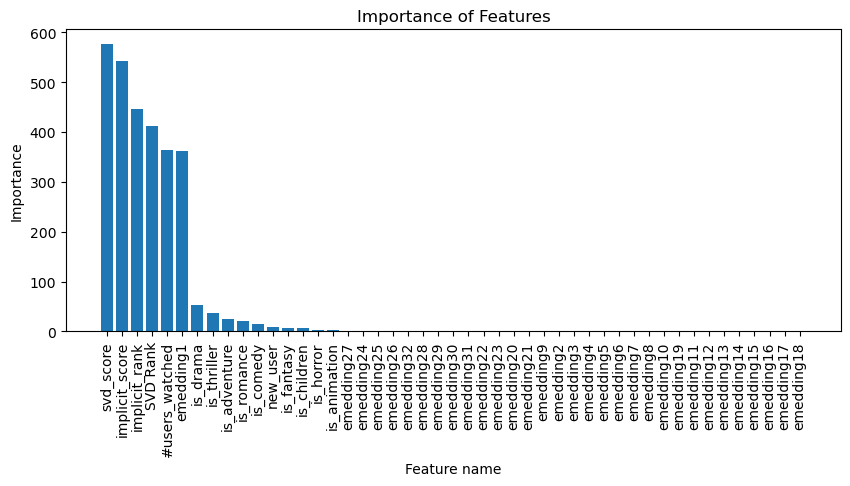

In [596]:
plot_feature_importances(features, importances)

In [597]:
importances

array([542, 446, 577,  15, 365,   8, 363,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  26,
        53,  22,   7,  38,   2,   6,   3, 412])

### No genre 

In [604]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature47))

In [605]:
len(features)

38

In [606]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [607]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             '#users_watched': feature5[i], 'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'SVD Rank': feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3685165949690455

In [608]:
lgbm_mrr, lgbm_map, lgbm_rr_nog, lgbm_ap_nog = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [609]:
print(stats.ttest_rel(lgbm_rr_nog,lgbm_rr_all_features))

Ttest_relResult(statistic=0.47272319275831176, pvalue=0.6364696269556798)


In [610]:
print(stats.ttest_rel(lgbm_ap_nog,lgbm_ap_all_features))

Ttest_relResult(statistic=1.4374036522679423, pvalue=0.1507821040227148)


In [612]:
print(stats.ttest_rel(ndcg_list,lgbm_ndcg_full))

Ttest_relResult(statistic=1.1653243764330574, pvalue=0.24404652659478213)


In [184]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [185]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368517,0.329367,0.373966,0.237178,0.186375,0.242007,0.133034,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'SVD Rank'],
      dtype='object')
38
38


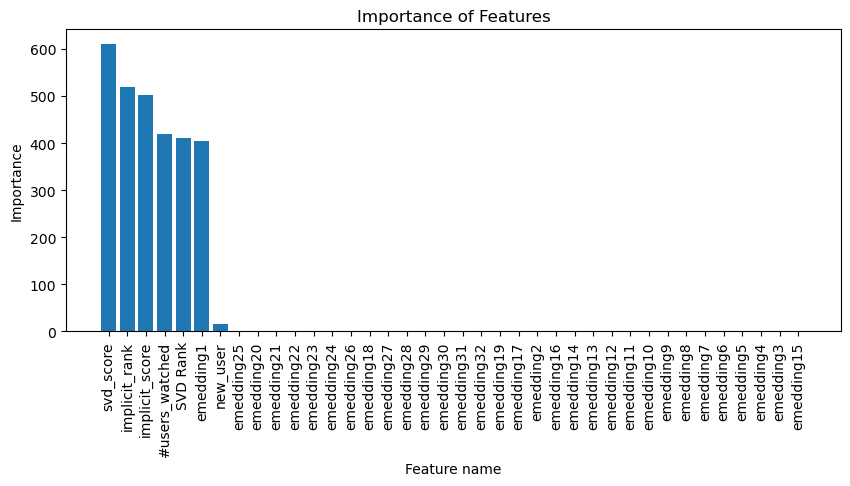

In [186]:
plot_feature_importances(features, importances)

In [187]:
st.spearmanr(np.array(feature2).reshape(len(num_users)*k,), np.array(feature1).reshape(len(num_users)*k,))

SpearmanrResult(correlation=-0.4866405531327332, pvalue=0.0)

In [188]:
#st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm.predict(X_test_no_genre).reshape(len(num_users)*k,))

In [189]:
#pred_no_genre = gbm.predict(X_test_no_genre)
#len(pred_no_genre)

In [190]:
importances

array([503, 519, 611, 419,  16, 404,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 412])

### Each genre's impact

#### Comedy

In [191]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [192]:
len(features)

39

In [193]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [194]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36775473172866757

In [195]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [196]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [197]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367755,0.329367,0.373966,0.235417,0.186375,0.242007,0.132432,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12', 'emedding13',
       'emedding14', 'emedding15', 'emedding16', 'emedding17', 'emedding18',
       'emedding19', 'emedding20', 'emedding21', 'emedding22', 'emedding23',
       'emedding24', 'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32', 'SVD Rank'],
      dtype='object')
39
39


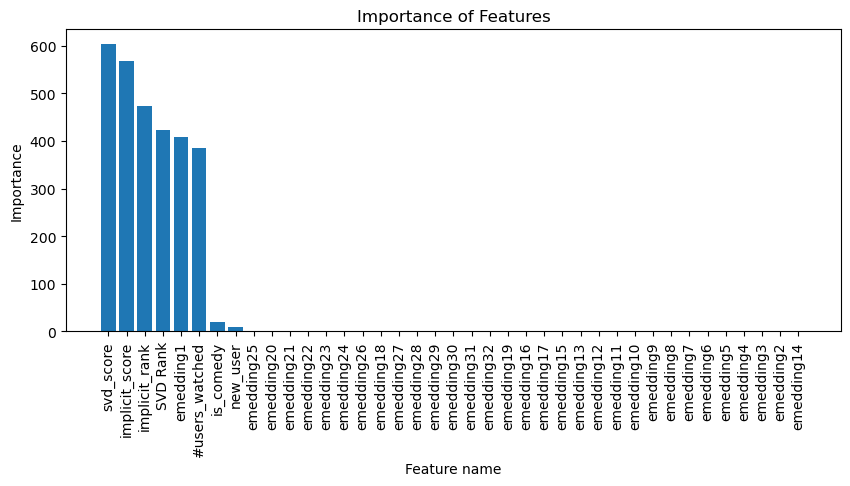

In [198]:
plot_feature_importances(features, importances)

In [199]:
importances

array([567, 474, 604,  19, 385,  10, 408,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 424])

#### Adventure

In [200]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature47))

In [201]:
len(features)

39

In [202]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [203]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36760835212554577

In [204]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [205]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [206]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367608,0.329367,0.373966,0.233958,0.186375,0.242007,0.13226,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'SVD Rank'],
      dtype='object')
39
39


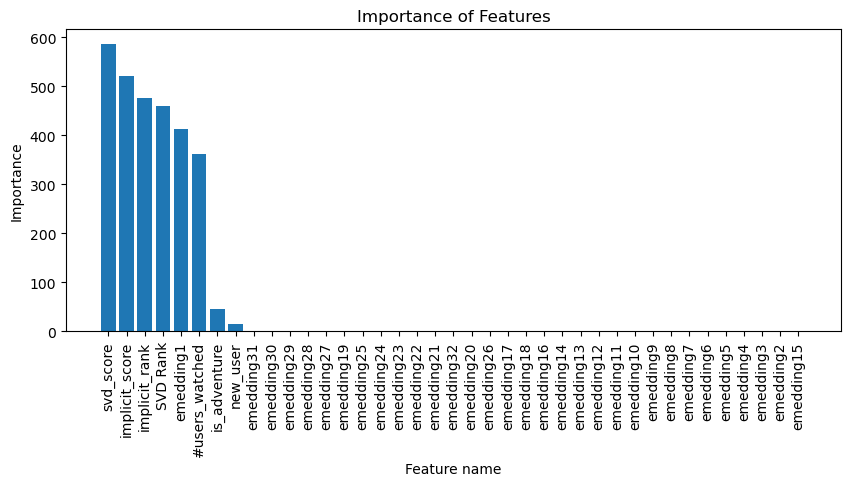

In [207]:
plot_feature_importances(features, importances)

In [208]:
importances

array([522, 477, 587, 363,  15, 413,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 460])

#### Drama

In [613]:
features = np.stack((feature1, feature2, feature3, 
                     feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature9,
                     feature47))

In [614]:
len(features)

39

In [615]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [616]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_drama': feature9[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_drama = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3683762202753002

In [617]:
lgbm_mrr, lgbm_map, lgbm_rr_drama, lgbm_ap_drama = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [618]:
print(stats.ttest_rel(lgbm_rr_drama,lgbm_rr_all_features))

Ttest_relResult(statistic=0.796777146417282, pvalue=0.4256885510000158)


In [619]:
print(stats.ttest_rel(lgbm_ap_drama,lgbm_ap_all_features))

Ttest_relResult(statistic=1.4164726231592237, pvalue=0.15681514739298555)


In [620]:
print(stats.ttest_rel(ndcg_list_drama,lgbm_ndcg_full))

Ttest_relResult(statistic=1.1131396253027213, pvalue=0.2658013413004673)


In [214]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [215]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368376,0.329367,0.373966,0.238538,0.186375,0.242007,0.132996,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_drama', 'SVD Rank'],
      dtype='object')
39
39


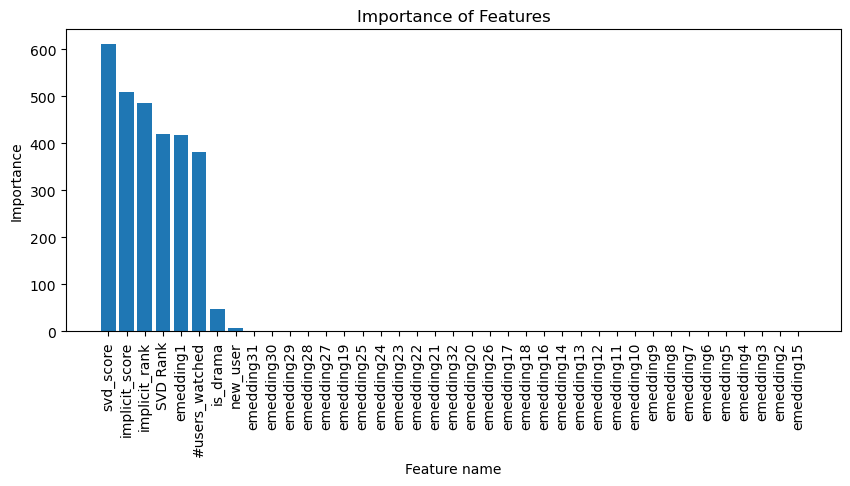

In [216]:
plot_feature_importances(features, importances)

In [217]:
importances

array([510, 487, 612, 382,   8, 418,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  47, 421])

#### Romance

In [218]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature10,
                     feature47))

In [219]:
len(features)

39

In [220]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [221]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_romance': feature10[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3670595267809884

In [222]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [223]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [224]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36706,0.329367,0.373966,0.23728,0.186375,0.242007,0.131228,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_romance', 'SVD Rank'],
      dtype='object')
39
39


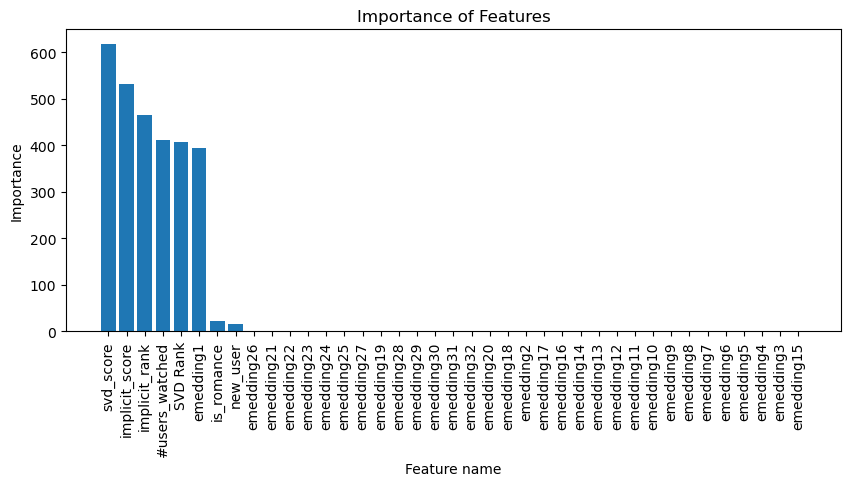

In [225]:
plot_feature_importances(features, importances)

In [226]:
importances

array([531, 466, 618, 411,  16, 394,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 407])

#### Fantasy

In [227]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature11,
                     feature47))

In [228]:
len(features)

39

In [229]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [230]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implcit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_fantasy': feature11[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3675610124668909

In [231]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [232]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [233]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367561,0.329367,0.373966,0.236696,0.186375,0.242007,0.132319,0.097554,0.140362


Index(['implcit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_fantasy', 'SVD Rank'],
      dtype='object')
39
39


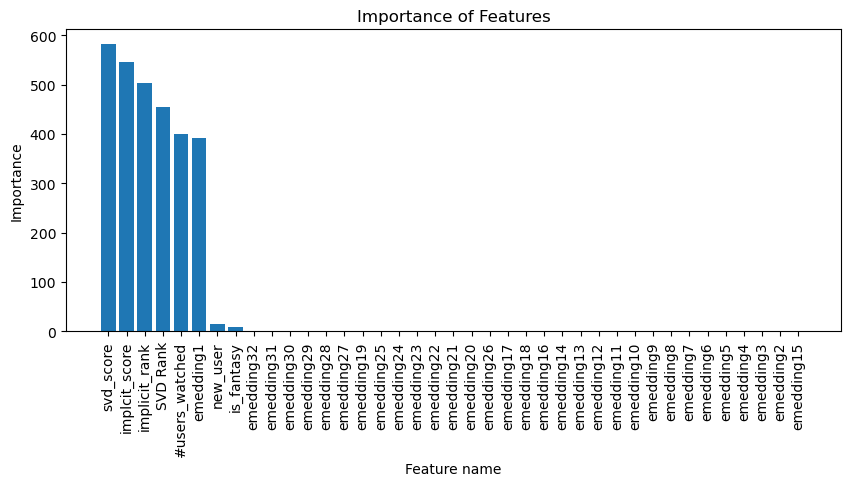

In [234]:
plot_feature_importances(features, importances)

In [235]:
importances

array([546, 503, 583, 401,  15, 392,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10, 454])

#### Thriller

In [236]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature12,
                     feature47))

In [237]:
len(features)

39

In [238]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [239]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_thriller': feature12[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36734529672079225

In [240]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [241]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [242]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367345,0.329367,0.373966,0.238068,0.186375,0.242007,0.132135,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_thriller', 'SVD Rank'],
      dtype='object')
39
39


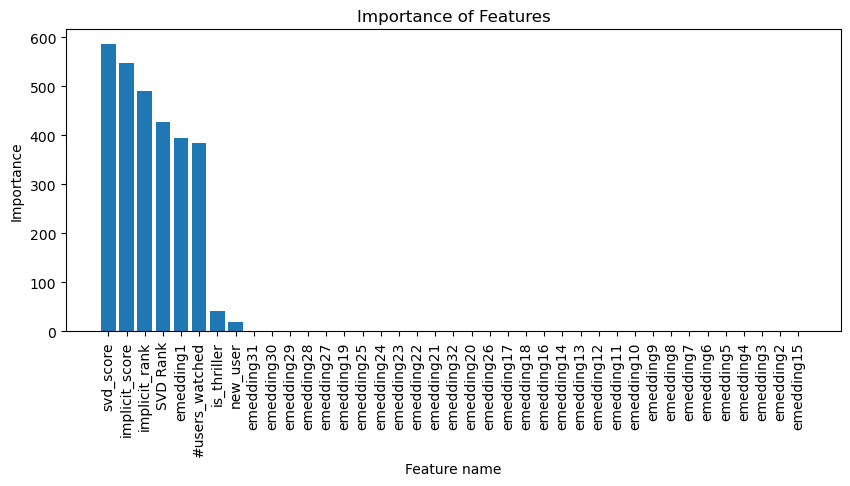

In [243]:
plot_feature_importances(features, importances)

In [244]:
importances

array([547, 490, 587, 384,  19, 395,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  41, 428])

#### Animation

In [245]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature13,
                     feature47))

In [246]:
len(features)

39

In [247]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [248]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_animation': feature13[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3679109510113131

In [249]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [250]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [251]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367911,0.329367,0.373966,0.23512,0.186375,0.242007,0.132573,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_animation', 'SVD Rank'],
      dtype='object')
39
39


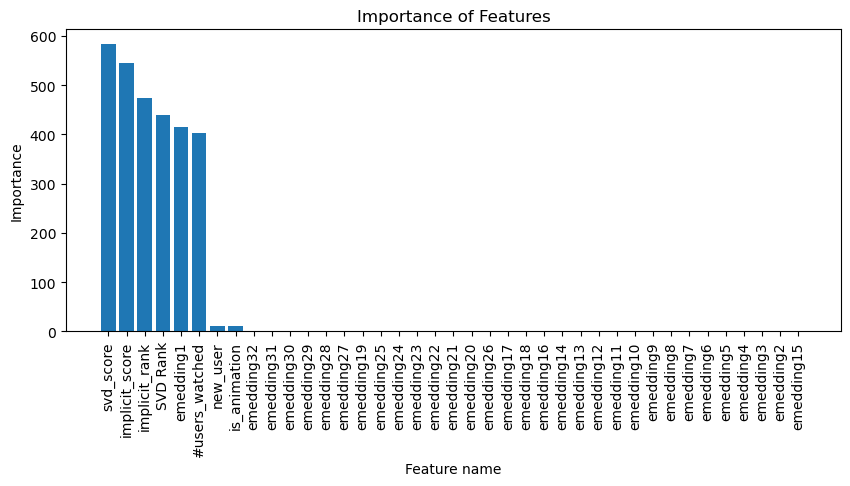

In [252]:
plot_feature_importances(features, importances)

In [253]:
importances

array([545, 474, 584, 403,  11, 415,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 440])

#### Children

In [254]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature14,
                     feature47))

In [255]:
len(features)

39

In [256]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [257]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_children': feature14[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3672125182731862

In [258]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [259]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [260]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367213,0.329367,0.373966,0.23368,0.186375,0.242007,0.131542,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_children', 'SVD Rank'],
      dtype='object')
39
39


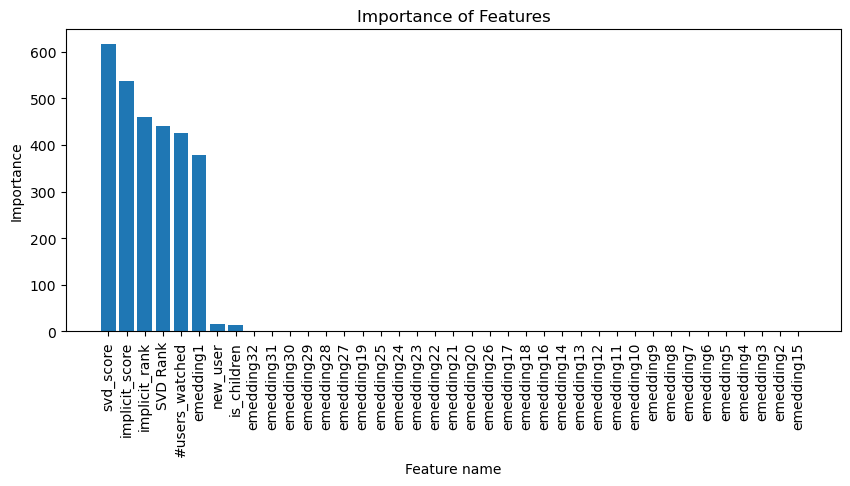

In [261]:
plot_feature_importances(features, importances)

In [262]:
importances

array([538, 460, 617, 426,  16, 378,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  14, 440])

#### Horror

In [621]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature15,
                     feature47))

In [622]:
len(features)

39

In [623]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [624]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_horror = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3685456949385591

In [625]:
lgbm_mrr, lgbm_map, lgbm_rr_horror, lgbm_ap_horror = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [626]:
print(stats.ttest_rel(lgbm_rr_horror,lgbm_rr_all_features))

Ttest_relResult(statistic=0.9326364149778658, pvalue=0.35113637688292476)


In [627]:
print(stats.ttest_rel(lgbm_ap_horror,lgbm_ap_all_features))

Ttest_relResult(statistic=1.5055460700072796, pvalue=0.1323642061792047)


In [628]:
print(stats.ttest_rel(ndcg_list_horror,lgbm_ndcg_full))

Ttest_relResult(statistic=1.215253517980237, pvalue=0.22443334043391444)


In [629]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [630]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368546,0.329367,0.373966,0.239577,0.186375,0.242007,0.133056,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_horror', 'SVD Rank'],
      dtype='object')
39
39


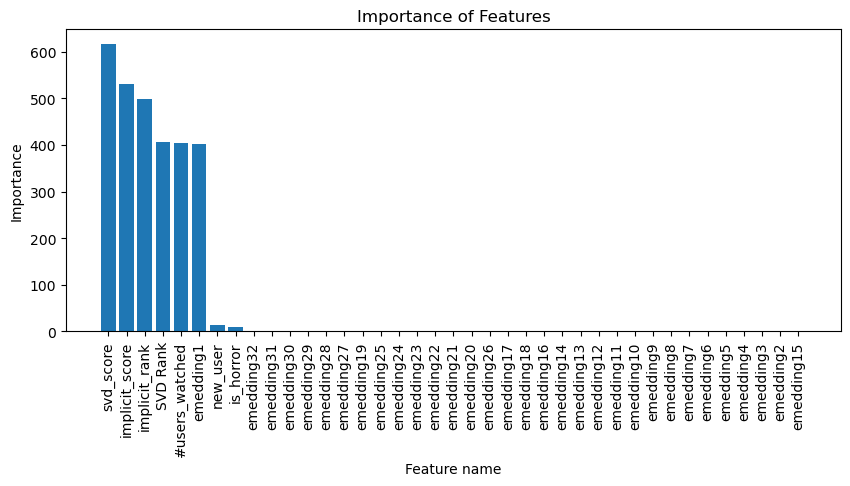

In [631]:
plot_feature_importances(features, importances)

In [271]:
importances

array([531, 499, 617, 405,  14, 402,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9, 406])

### Keeping the top genres

In [632]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature9, feature15, feature47))

In [633]:
len(features)

40

In [634]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [635]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_drama': feature9[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_both = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36745041820802615

In [636]:
lgbm_mrr, lgbm_map, lgbm_rr_both, lgbm_ap_both = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [637]:
print(stats.ttest_rel(lgbm_rr_both,lgbm_rr_all_features))

Ttest_relResult(statistic=0.27619585612492015, pvalue=0.7824302526497483)


In [638]:
print(stats.ttest_rel(lgbm_ap_both,lgbm_ap_all_features))

Ttest_relResult(statistic=0.9025937308384562, pvalue=0.3668657692076921)


In [639]:
print(stats.ttest_rel(ndcg_list_both,lgbm_ndcg_full))

Ttest_relResult(statistic=0.48682147491986993, pvalue=0.6264458152516589)


In [640]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [641]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36745,0.329367,0.373966,0.236102,0.186375,0.242007,0.132194,0.097554,0.140362


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_drama', 'is_horror',
       'SVD Rank'],
      dtype='object')
40
40


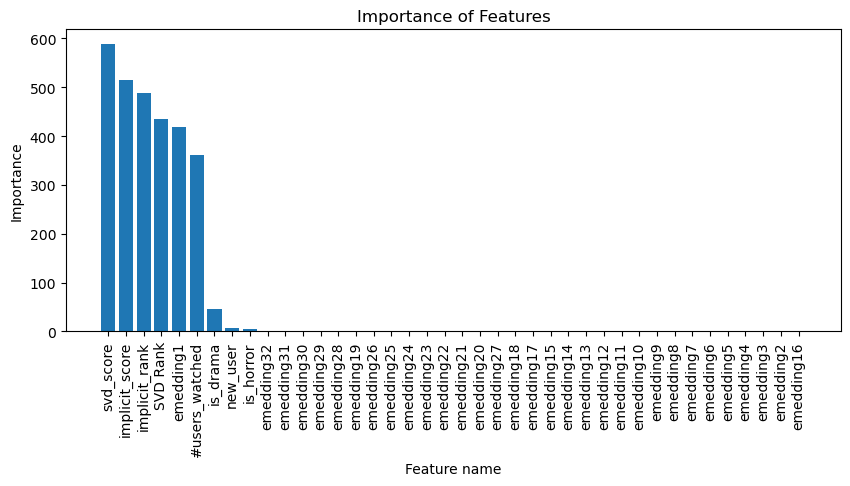

In [642]:
plot_feature_importances(features, importances)

In [643]:
importances

array([515, 489, 589, 362,   8, 418,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  47,   5,
       436])

## What is the impact of items' embeddings features on the effectiveness of a model for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No item embeddings features

In [644]:
features = np.stack((feature1,feature2,feature3,feature4,feature5,feature6,feature8,
                              feature9,feature10,feature11,feature12,feature13,
                              feature14,feature15,feature47))

In [645]:
len(features)

15

In [646]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [647]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_noemb = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36940674486863206

In [649]:
lgbm_mrr, lgbm_map, lgbm_rr_noemb, lgbm_ap_noemb = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [650]:
print(stats.ttest_rel(lgbm_rr_noemb,lgbm_rr_all_features))

Ttest_relResult(statistic=1.3436204868322188, pvalue=0.17924532899561466)


In [651]:
print(stats.ttest_rel(lgbm_ap_noemb,lgbm_ap_all_features))

Ttest_relResult(statistic=1.6803759443069402, pvalue=0.09306266238721521)


In [652]:
print(stats.ttest_rel(ndcg_list_noemb,lgbm_ndcg_full))

Ttest_relResult(statistic=1.587696538031919, pvalue=0.11253562402940899)


In [653]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [654]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.369407,0.329367,0.373966,0.241848,0.186375,0.242007,0.133692,0.097554,0.140362


In [655]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'is_adventure', 'is_drama', 'is_romance',
       'is_fantasy', 'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'SVD Rank'],
      dtype='object')
15
15


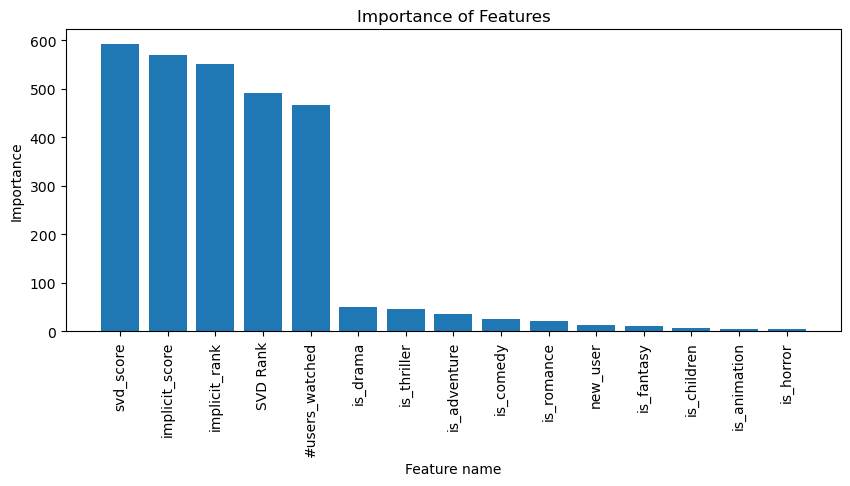

In [656]:
plot_feature_importances(features, importances)

In [657]:
importances

array([571, 551, 593,  25, 467,  13,  36,  50,  22,  11,  46,   5,   7,
         5, 491])

### First Embedding only

In [666]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature8,
                     feature9, feature10, feature11, feature12, feature13,
                     feature14, feature15, feature47))

In [667]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [668]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_firstemb = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36671023993045043

In [669]:
lgbm_mrr, lgbm_map, lgbm_rr_firstemb, lgbm_ap_firstemb = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [670]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [671]:
print(stats.ttest_rel(lgbm_rr_firstemb,lgbm_rr_all_features))

Ttest_relResult(statistic=nan, pvalue=nan)


C:\Users\papad\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [672]:
print(stats.ttest_rel(lgbm_ap_firstemb,lgbm_ap_all_features))

Ttest_relResult(statistic=nan, pvalue=nan)


In [673]:
print(stats.ttest_rel(ndcg_list_firstemb,lgbm_ndcg_full))

Ttest_relResult(statistic=nan, pvalue=nan)


In [674]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36671,0.329367,0.373966,0.234786,0.186375,0.242007,0.130753,0.097554,0.140362


In [297]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD Rank'],
      dtype='object')
16
16


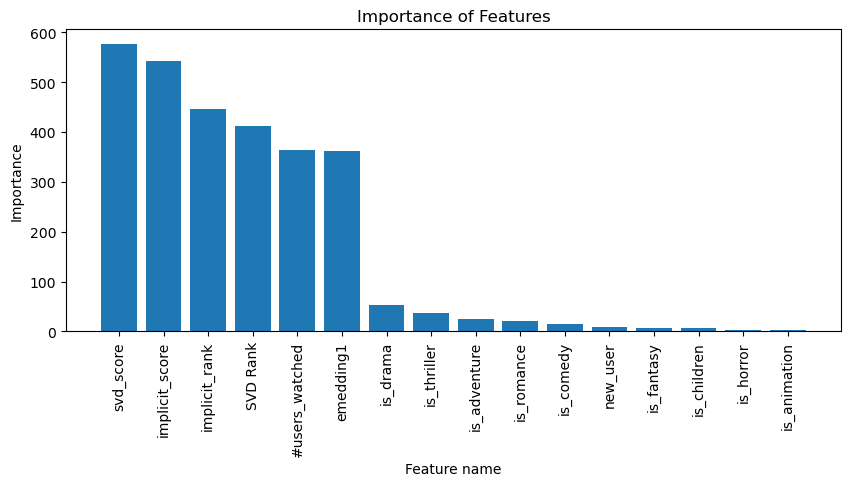

In [298]:
plot_feature_importances(features, importances)

In [299]:
importances

array([542, 446, 577,  15, 365,   8, 363,  26,  53,  22,   7,  38,   2,
         6,   3, 412])

## What is the impact of the items’rank on the effectiveness of amodel for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No models' rank features

In [675]:
features = np.stack((feature1, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15))

In [676]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [677]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_no_rank = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36628286843030594

In [678]:
lgbm_mrr, lgbm_map, lgbm_rr_no_rank, lgbm_ap_no_rank = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [679]:
print(stats.ttest_rel(lgbm_rr_no_rank,lgbm_rr_all_features))

Ttest_relResult(statistic=-1.4149059185018644, pvalue=0.15727399065327913)


In [680]:
print(stats.ttest_rel(lgbm_ap_no_rank,lgbm_ap_all_features))

Ttest_relResult(statistic=0.6688597918533612, pvalue=0.5036731409464021)


In [681]:
print(stats.ttest_rel(ndcg_list_no_rank,lgbm_ndcg_full))

Ttest_relResult(statistic=-0.2215923842370655, pvalue=0.8246570651712666)


In [682]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [683]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.366283,0.329367,0.373966,0.226193,0.186375,0.242007,0.132051,0.097554,0.140362


In [684]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'svd_score', 'is_comedy', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror'],
      dtype='object')
45
45


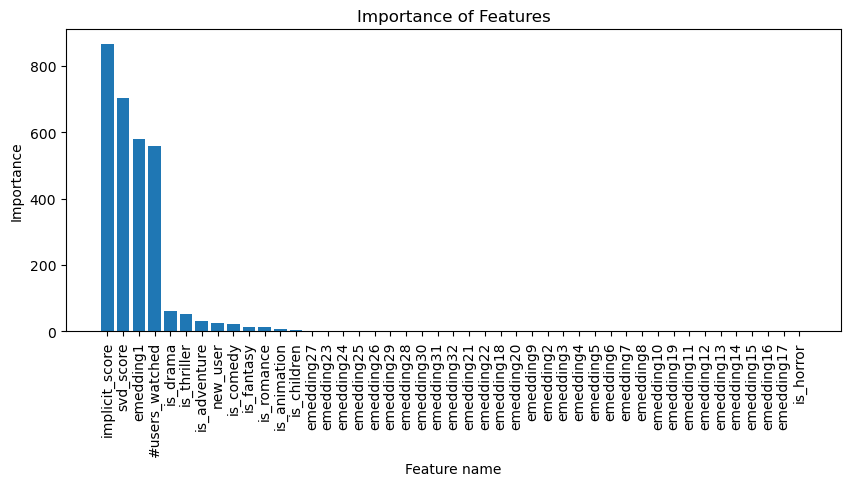

In [685]:
plot_feature_importances(features, importances)

In [686]:
importances

array([867, 704,  23, 558,  25, 579,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  33,  63,
        13,  13,  53,   7,   5,   0])

### Without Implicit Rank

In [687]:
features = np.stack((feature1, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [688]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [690]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_no_IFM_rank = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36799115412474676

In [691]:
lgbm_mrr, lgbm_map, lgbm_rr_no_IFM_rank, lgbm_ap_no_IFM_rank = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [692]:
print(stats.ttest_rel(lgbm_rr_no_IFM_rank,lgbm_rr_all_features))

Ttest_relResult(statistic=-0.10167156520629254, pvalue=0.9190290203155255)


In [693]:
print(stats.ttest_rel(lgbm_ap_no_IFM_rank,lgbm_ap_all_features))

Ttest_relResult(statistic=1.4706669070218974, pvalue=0.14156099285258833)


In [694]:
print(stats.ttest_rel(ndcg_list_no_IFM_rank,lgbm_ndcg_full))

Ttest_relResult(statistic=0.700506602547634, pvalue=0.48370410349132276)


In [695]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [696]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367991,0.329367,0.373966,0.234206,0.186375,0.242007,0.133514,0.097554,0.140362


In [697]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'svd_score', 'is_comedy', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD_rank'],
      dtype='object')
46
46


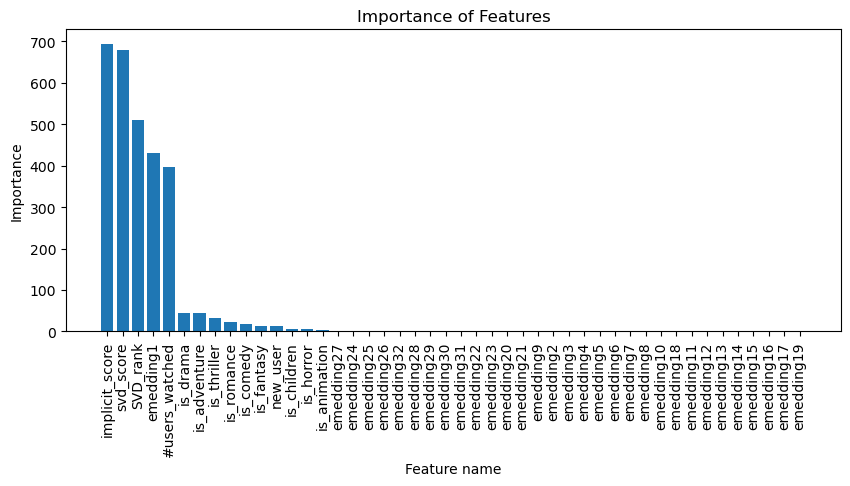

In [698]:
plot_feature_importances(features, importances)

In [699]:
importances

array([694, 679,  18, 397,  12, 431,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44,  45,
        24,  13,  32,   3,   7,   5, 511])

### Without SVD Rank

In [701]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15))

In [702]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [703]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_no_SVD_rank = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3711391105674379

In [704]:
lgbm_mrr, lgbm_map, lgbm_rr_no_SVD_rank, lgbm_ap_no_SVD_rank = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [705]:
print(stats.ttest_rel(lgbm_rr_no_SVD_rank,lgbm_rr_all_features))

Ttest_relResult(statistic=1.640302345681805, pvalue=0.101122032581048)


In [706]:
print(stats.ttest_rel(lgbm_ap_no_SVD_rank,lgbm_ap_all_features))

Ttest_relResult(statistic=2.516250807970783, pvalue=0.011949901567829043)


In [707]:
print(stats.ttest_rel(ndcg_list_no_SVD_rank,lgbm_ndcg_full))

Ttest_relResult(statistic=2.2894823399687643, pvalue=0.0221699211591289)


In [708]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [709]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.371139,0.329367,0.373966,0.244317,0.186375,0.242007,0.135878,0.097554,0.140362


In [710]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12', 'emedding13',
       'emedding14', 'emedding15', 'emedding16', 'emedding17', 'emedding18',
       'emedding19', 'emedding20', 'emedding21', 'emedding22', 'emedding23',
       'emedding24', 'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32', 'is_adventure',
       'is_drama', 'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror'],
      dtype='object')
46
46


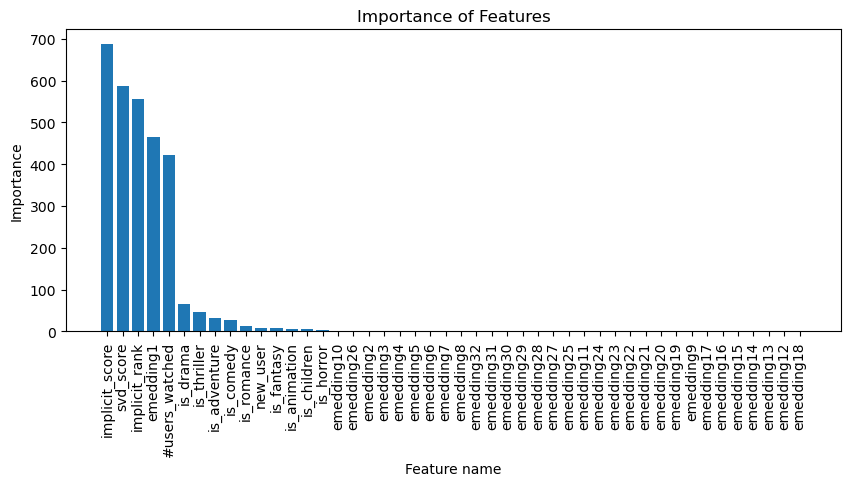

In [711]:
plot_feature_importances(features, importances)

In [712]:
importances

array([688, 556, 588,  28, 422,   9, 464,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  33,
        65,  14,   8,  47,   7,   6,   3])

## What is the impact of the baseline scores?

### No models' scores

In [327]:
features = np.stack((feature2, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [328]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [329]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'IFM_rank': feature2[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i], 'SVD_rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3682203167109245

In [330]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [331]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [332]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36822,0.329367,0.373966,0.249824,0.186375,0.242007,0.131556,0.097554,0.140362


In [333]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['IFM_rank', 'is_comedy', '#users_watched', 'new_user', 'emedding1',
       'emedding2', 'emedding3', 'emedding4', 'emedding5', 'emedding6',
       'emedding7', 'emedding8', 'emedding9', 'emedding10', 'emedding11',
       'emedding12', 'emedding13', 'emedding14', 'emedding15', 'emedding16',
       'emedding17', 'emedding18', 'emedding19', 'emedding20', 'emedding21',
       'emedding22', 'emedding23', 'emedding24', 'emedding25', 'emedding26',
       'emedding27', 'emedding28', 'emedding29', 'emedding30', 'emedding31',
       'emedding32', 'is_adventure', 'is_drama', 'is_romance', 'is_fantasy',
       'is_thriller', 'is_animation', 'is_children', 'is_horror', 'SVD_rank'],
      dtype='object')
45
45


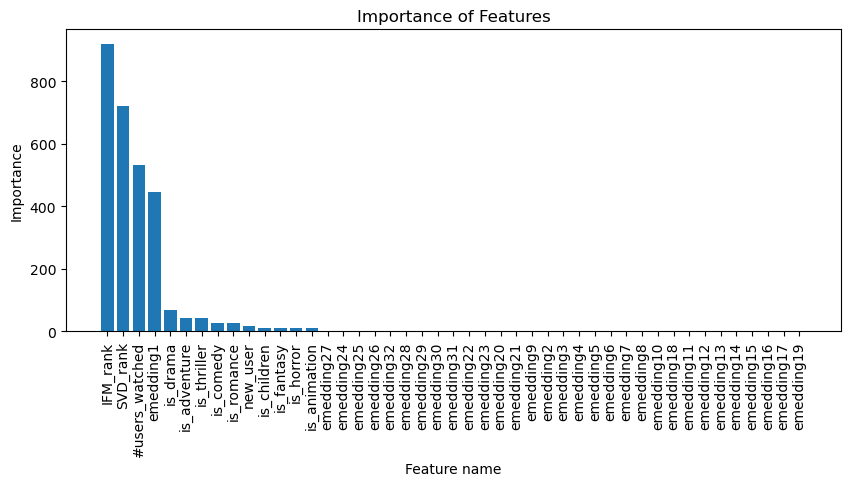

In [334]:
plot_feature_importances(features, importances)

In [335]:
importances

array([920,  27, 532,  18, 445,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44,  68,  26,
        12,  43,  10,  12,  11, 720])

### Without IFM's score

In [484]:
features = np.stack((feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [485]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [486]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'ifm_rank':feature2[i],
                         'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36893840810054185

In [487]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [488]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [489]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368938,0.329367,0.373966,0.240383,0.186375,0.242007,0.133638,0.097554,0.140362


In [490]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['ifm_rank', 'svd_score', 'is_comedy', '#users_watched', 'new_user',
       'emedding1', 'emedding2', 'emedding3', 'emedding4', 'emedding5',
       'emedding6', 'emedding7', 'emedding8', 'emedding9', 'emedding10',
       'emedding11', 'emedding12', 'emedding13', 'emedding14', 'emedding15',
       'emedding16', 'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24', 'emedding25',
       'emedding26', 'emedding27', 'emedding28', 'emedding29', 'emedding30',
       'emedding31', 'emedding32', 'is_adventure', 'is_drama', 'is_romance',
       'is_fantasy', 'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'SVD_rank'],
      dtype='object')
46
46


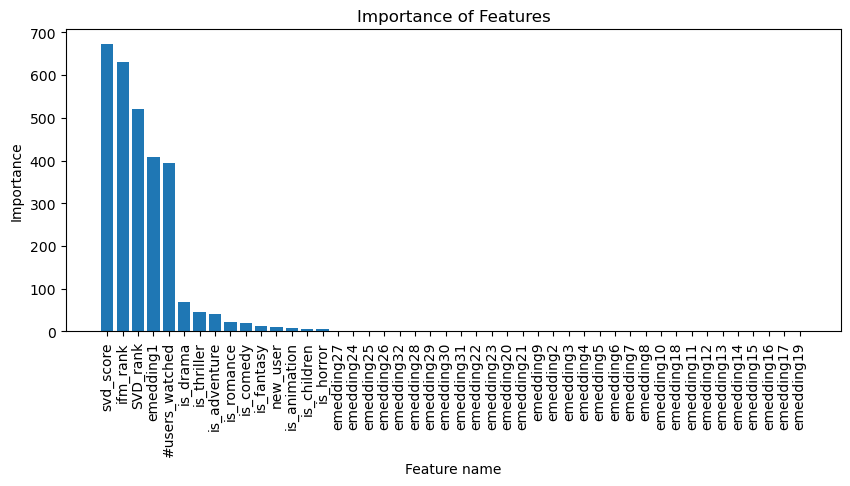

In [491]:
plot_feature_importances(features, importances)

In [344]:
importances

array([631, 673,  20, 394,  11, 409,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42,  69,
        22,  12,  45,   7,   6,   5, 520])

### Without SVD's score

In [492]:
features = np.stack((feature1, feature2, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [493]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [494]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i], 
                         'ifm_rank': feature2[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'svd_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36569885651495754

In [495]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [496]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [497]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.365699,0.329367,0.373966,0.235173,0.186375,0.242007,0.12926,0.097554,0.140362


In [498]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'ifm_rank', 'is_comedy', '#users_watched', 'new_user',
       'emedding1', 'emedding2', 'emedding3', 'emedding4', 'emedding5',
       'emedding6', 'emedding7', 'emedding8', 'emedding9', 'emedding10',
       'emedding11', 'emedding12', 'emedding13', 'emedding14', 'emedding15',
       'emedding16', 'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24', 'emedding25',
       'emedding26', 'emedding27', 'emedding28', 'emedding29', 'emedding30',
       'emedding31', 'emedding32', 'is_adventure', 'is_drama', 'is_romance',
       'is_fantasy', 'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'svd_rank'],
      dtype='object')
46
46


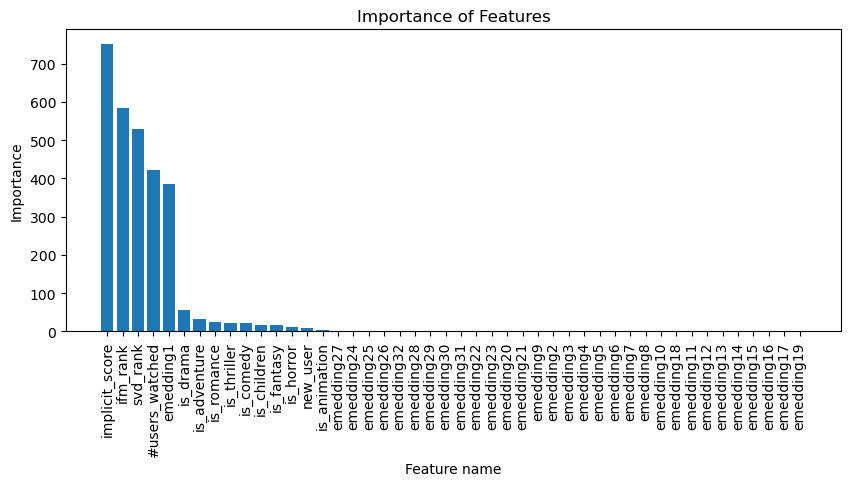

In [499]:
plot_feature_importances(features, importances)

In [500]:
importances

array([752, 585,  22, 422,   8, 386,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32,  56,
        24,  17,  23,   4,  17,  13, 530])

## Best feature combinations

In [354]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [355]:
len(features)

47

In [356]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

None


In [357]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                         'rank': feature2[i], 'model2_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36671023993045043

In [358]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [359]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [360]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36671,0.329367,0.373966,0.234786,0.186375,0.242007,0.130753,0.097554,0.140362


In [361]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['model1_score', 'rank', 'model2_score', 'is_comedy', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD Rank'],
      dtype='object')
47
47


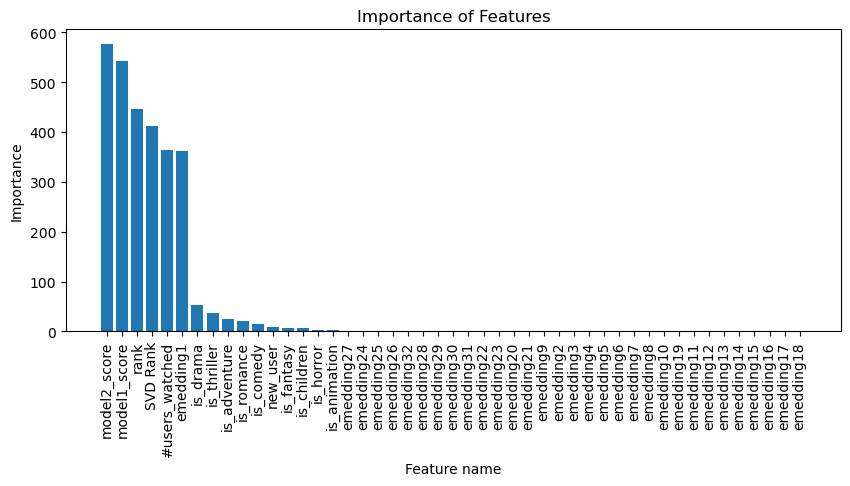

In [362]:
plot_feature_importances(features, importances)

In [363]:
importances

array([542, 446, 577,  15, 365,   8, 363,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  26,
        53,  22,   7,  38,   2,   6,   3, 412])

# Draft

In [453]:
train_features_df['movie_id'].unique()

11024

In [457]:
movies_df[movies_df['movieId'] == train_features_df['movie_id'][0]]['genres']

292    Comedy|Crime|Drama|Thriller
Name: genres, dtype: object

In [472]:
count = 0
for i in range(len(train_features_df['movie_id'].unique())):
    a =  movies_df[movies_df['movieId'] == train_features_df['movie_id'][i]]['genres']
    a = a.tolist()
    a = str(a[0])
    a = a.split('|')
    if 'Thriller' in a:
        count += 1

In [473]:
#horror 863
#adventure 2509
#comedy 3962
#drama 4796
#thriller 2977
count
# rr before and after
#less than 0.05 in the p-value

2977

In [475]:
from scipy import stats
rvs1 = stats.norm.rvs(loc = 5,scale = 10,size = 500)
rvs2 = stats.norm.rvs(loc = 5,scale = 10,size = 500)


Ttest_indResult(statistic=-0.40331379088750186, pvalue=0.6868037874359643)


In [476]:
print(stats.ttest_ind(rvs1,rvs2))

array([ 1.42617755e+01,  2.40941664e+01, -8.98567574e+00,  1.06296924e+01,
       -1.50642569e+00,  1.28746162e-01, -9.23939242e-01, -3.63990770e+00,
        5.48521628e+00, -3.30950116e+00,  7.70456826e+00,  4.49761891e+00,
        2.61051953e+00, -4.07563662e+00, -7.67713306e-01,  1.25539123e+01,
        1.00091719e+01, -4.77555245e+00,  5.99332305e+00,  1.25138712e+01,
       -1.16940528e+01,  1.04336019e+01, -1.62623759e+00,  1.07059867e+01,
       -2.63259157e+00, -1.30488210e+01, -1.12754244e+01,  5.48084947e+00,
        7.59722502e+00, -4.04316625e+00,  1.13859246e+01, -1.16152006e+01,
        4.33920201e+00, -7.11016200e+00, -1.51836108e+00,  5.47398671e+00,
       -3.60413365e+00,  1.15444456e+00,  1.50629281e+01, -7.68918695e-01,
        1.33569211e+01, -6.29706855e+00,  1.02980418e+01,  1.94156862e+01,
       -1.97164450e+01, -2.96895255e+00,  1.07707213e+01,  2.96954614e+00,
        8.71145873e+00, -1.03985187e+00,  5.86589787e+00,  3.44322765e+00,
        1.66778206e+01,  

## Excel-Like

In [364]:
excel1_df = pd.DataFrame({'movie_id': target_movies[0],'rank':feature2[0],'model1_score':feature1[0], 'model2_score':feature3[0],'is_comedy':feature4[0],
                            '#users_watched':feature5[0], 'train_label':label_train[0], 'test_label':label_test[0],
                            'label_val':label_val[0],'LGBM Score':lgbm_pred_per_user[0]})

In [365]:
excel1_df

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,293,1.0,11.013071,0.133414,0,348,0,0,0,-1.683480
1,266,2.0,10.311844,-0.003312,0,171,0,0,0,-1.515641
2,370,3.0,10.272123,-0.022393,1,137,0,0,0,-1.691471
3,110,4.0,10.202899,0.001836,0,626,0,0,0,-1.795091
4,349,6.0,9.976336,-0.093739,0,303,0,0,0,-2.941355
...,...,...,...,...,...,...,...,...,...,...
145,318,8016.0,9.837716,0.201986,0,861,0,0,0,0.139133
146,3032,8305.0,-4.189871,-0.006590,0,13,0,0,0,-2.755281
147,410,8438.0,7.493887,-0.042678,1,200,0,0,0,-2.924018
148,353,12756.0,6.425072,-0.006972,0,164,0,0,0,-2.745498


In [366]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
14,296,17.0,9.398109,0.299885,1,861,1,0,0,0.752534
61,2858,89.0,8.300941,0.314336,0,546,0,0,0,0.170838
145,318,8016.0,9.837716,0.201986,0,861,0,0,0,0.139133
7,318,9.0,9.837716,0.201986,0,861,0,0,0,0.031824
54,50,74.0,8.382501,0.219228,0,601,0,0,0,-0.139450
100,1704,244.0,7.538413,0.171830,0,401,0,0,0,-0.169498
80,1193,149.0,8.064758,0.270607,0,359,0,0,0,-0.210100
48,1258,63.0,8.502443,0.212148,0,285,0,0,0,-0.284241
102,4226,267.0,7.385221,0.221870,0,416,0,0,0,-0.380973
45,1213,57.0,8.542473,0.253754,0,338,0,0,0,-0.397315


In [367]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [368]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


nan

In [369]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

NameError: name 'predicted_rank_svd' is not defined

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

## KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]

In [ ]:
excel_df

## Implicit Sequence model

In [ ]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

### Train Implicit Sequence model

In [ ]:
'''sequence_model  = ImplicitSequenceModel(n_iter = 5)

current = time.time()
sequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

In [ ]:
#sequence_model.predict(sequences = 9724)

### MRR Score

In [ ]:
#print(sequence_mrr_score(sequence_model, implicit_test.to_sequence()).mean())

### Top-K predictions for a user

In [ ]:
#allUsers_topK_sequence = allUsers_topK_implicit(sequence_model)

### NDCG Score

In [ ]:
#relevance_sequence_full = relevance_spotlight_implicit(allUsers_topK_sequence)

In [ ]:
#allUsers_sequence_ndcg = allUsers_ndcg(relevance_sequence_full)

In [ ]:
#allUsers_sequence_ndcg = pd.Series(allUsers_sequence_ndcg).fillna(0).tolist()

### MAP

In [ ]:
'''ran = [1,0,1,1,0]
ran = r2
count_positive = 0
positives = []
ap_perUser = []
count = 0
for r in ran:
    #for i in range(len(relevance[0])):
    count += 1
    if r == 1:
        count_positive += 1
        positives.append(count_positive/count)
ap_perUser.append(np.array(positives).sum()/count_positive)
count_positive = 0
positives = []'''

In [ ]:
#ap_perUser

In [ ]:
r_f = []
r_f.append([1,0,1,1,0])
r_f.append([0,0,0,1,1])

In [ ]:
r_f

In [ ]:
rap = calculate_averagePrecision(r_f)

In [ ]:
rap

In [ ]:
rmap = calculate_MAP(rap)
rmap

### MRR

In [ ]:
len(af)

In [ ]:
afrr = RR_forUsers(af)
mrr_af = calculate_mrr(afrr)

In [ ]:
mrr_af

### Built-in MRR score

In [ ]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

### Second NDCG Score

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [ ]:
'''def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations'''

In [ ]:
'''already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
predictions.head()'''

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [ ]:
'''def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions'''

#### NDCG Score

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [ ]:
'''def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full'''

In [ ]:
#svd_relevance = SVD_relevance()

In [ ]:
#allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)

In [517]:
count = 0
for u in range(len(num_users)):
    for i in range(150):
        if feature8[j][i] == 1:
            count += 1

In [518]:
count

71791

In [ ]:
#comedy 81772
#horror 12257
#adventure 165820
